## CAPSTONE PROJECT

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### IMPORT PACKAGES

In [2]:
!pip install pmdarima > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm
import pickle

#### READ DATASET

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Narasio/SDS/Capstone/Dataset Time Series.xlsx')
df['tanggal'] = pd.to_datetime(df['tanggal'], format = '%Y-%m-%d')
df

,indeks,tanggal,kode_toko,barang,penjualan,promosi
0,0,2013-01-01,AFK1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,AFK1,BABY CARE,0.000,0
2,2,2013-01-01,AFK1,BEAUTY,0.000,0
3,3,2013-01-01,AFK1,BEVERAGES,0.000,0
4,4,2013-01-01,AFK1,BOOKS,0.000,0
...,...,...,...,...,...,...
77710,1048570,2014-08-13,AFK3,POULTRY,974.098,1
77711,1048571,2014-08-13,AFK3,PREPARED FOODS,324.293,0
77712,1048572,2014-08-13,AFK3,PRODUCE,10.000,1
77713,1048573,2014-08-13,AFK3,SCHOOL AND OFFICE SUPPLIES,0.000,0


####EDA

Text(0, 0.5, 'Penjualan (per 10.000.000)')

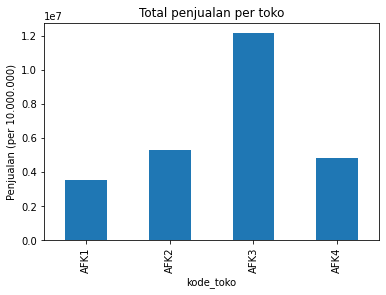

In [5]:
ax1 = df[['kode_toko','penjualan']].groupby(['kode_toko']).sum().plot(kind= 'bar',legend = False,title='Total penjualan per toko')
ax1.set_ylabel('Penjualan (per 10.000.000)')

Text(0, 0.5, 'Penjualan by Toko by Produk (juta)')

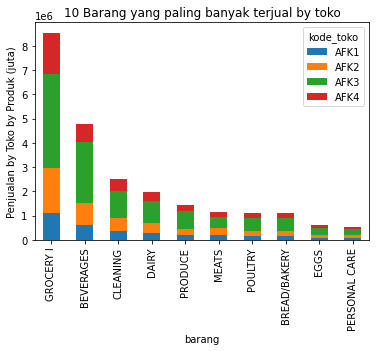

In [6]:
df_pivot = df.pivot_table(index = 'barang', columns = 'kode_toko' , values = 'penjualan',aggfunc= 'sum')
df_pivot['sum_col'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values(by=['sum_col'],ascending = False).iloc[:10]
df_pivot.drop(columns = ['sum_col'], inplace=True)
ax = df_pivot.plot(kind = 'bar', stacked = True,title = '10 Barang yang paling banyak terjual by toko')
ax.set_ylabel('Penjualan by Toko by Produk (juta)')

Text(0, 0.5, 'Jumlah Promosi')

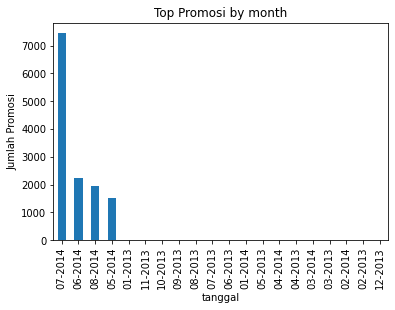

In [67]:
#Promosi yang dilakukan per bulan
df_prom = df[['tanggal', 'promosi',]]
ax_prom = df_prom.groupby(df_prom['tanggal'].dt.strftime('%m-%Y'))['promosi'].sum().sort_values(ascending=False).plot(kind = 'bar',title = 'Top Promosi by month')
ax_prom.set_ylabel('Jumlah Promosi')

Tidak ditemukan bukti bahwa korelasi mempengaruhi sales (kurang data promosi pada mayoritas bulan)

Text(0.5, 0, 'Bulan')

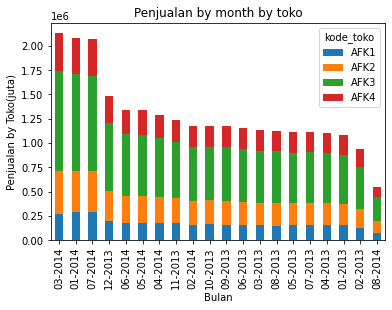

In [8]:
df_pen = df.pivot_table(index= df['tanggal'].dt.strftime('%m-%Y'), columns = 'kode_toko',values = 'penjualan', aggfunc='sum')
df_pen['sum_col'] = df_pen.sum(axis=1)
df_pen = df_pen.sort_values(by=['sum_col'],ascending = False)
df_pen.drop(columns = ['sum_col'], inplace=True)
ax_pen = df_pen.plot(kind = 'bar', stacked = True,title = 'Penjualan by month by toko')
ax_pen.set_ylabel('Penjualan by Toko(juta)')
ax_pen.set_xlabel('Bulan')

#### DATA PRE-PROCESSING

In [9]:
#Check Missing Values
df.isnull().sum()

indeks       0
tanggal      0
kode_toko    0
barang       0
penjualan    0
promosi      0
dtype: int64

In [10]:
#check for any duplicates in the data
len(df[df.duplicated()==True])

0

In [11]:
print(pd.date_range(
  start="2013-01-01", end="2014-08-13").difference(df.tanggal))

DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)


In [12]:
#Missing value in 2013-12-25
df1 = df[df['kode_toko'] == 'AFK1'][['tanggal','penjualan','promosi']]
df1 = df1.groupby(['tanggal']).sum()

In [13]:
print(pd.date_range(
  start="2013-01-01", end="2014-08-13").difference(df1.index))

DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)


In [14]:
df1 = df1.asfreq('D')
df1

,penjualan,promosi
tanggal,,
2013-01-01,0.000000,0.0
2013-01-02,7417.148000,0.0
2013-01-03,5873.244001,0.0
2013-01-04,5919.879001,0.0
2013-01-05,6318.785010,0.0
...,...,...
2014-08-09,5666.582999,16.0
2014-08-10,2320.304000,11.0
2014-08-11,6019.558000,7.0


In [15]:
df2 = df[df['kode_toko'] == 'AFK2'][['tanggal','penjualan','promosi']]
df2 = df2.groupby(['tanggal']).sum()
df2

,penjualan,promosi
tanggal,,
2013-01-01,0.000000,0
2013-01-02,10266.718981,0
2013-01-03,7612.540000,0
2013-01-04,7526.377000,0
2013-01-05,9539.566000,0
...,...,...
2014-08-09,9814.150000,15
2014-08-10,9930.367000,14
2014-08-11,8689.834020,10


In [16]:
print(pd.date_range(
  start="2013-01-01", end="2014-08-13").difference(df2.index))

DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)


In [17]:
df2 = df2.asfreq('D')
df2

,penjualan,promosi
tanggal,,
2013-01-01,0.000000,0.0
2013-01-02,10266.718981,0.0
2013-01-03,7612.540000,0.0
2013-01-04,7526.377000,0.0
2013-01-05,9539.566000,0.0
...,...,...
2014-08-09,9814.150000,15.0
2014-08-10,9930.367000,14.0
2014-08-11,8689.834020,10.0


In [18]:
df3 = df[df['kode_toko'] == 'AFK3'][['tanggal','penjualan','promosi']]
df3 = df3.groupby(['tanggal']).sum()

In [19]:
print(pd.date_range(
  start="2013-01-01", end="2014-08-13").difference(df3.index))

DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)


In [20]:
df3 = df3.asfreq('D')
df3

,penjualan,promosi
tanggal,,
2013-01-01,0.000000,0.0
2013-01-02,24060.348000,0.0
2013-01-03,18570.745025,0.0
2013-01-04,17392.097995,0.0
2013-01-05,22700.872005,0.0
...,...,...
2014-08-09,20565.606000,25.0
2014-08-10,22477.569020,14.0
2014-08-11,17602.810000,14.0


In [21]:
df4 = df[df['kode_toko'] == 'AFK4'][['tanggal','penjualan','promosi']]
df4 = df4.groupby(['tanggal']).sum()
df4 = df4.asfreq('D')
df4 = df4.reset_index()
df4.loc[589] = [datetime.strptime('2014-08-13', '%Y-%m-%d'),df4.loc[588]['penjualan'],df4.loc[588]['promosi']]
df4.set_index('tanggal',inplace=True)
df4

,penjualan,promosi
tanggal,,
2013-01-01,0.000000,0.0
2013-01-02,10200.083980,0.0
2013-01-03,7400.245000,0.0
2013-01-04,6902.050001,0.0
2013-01-05,9948.383000,0.0
...,...,...
2014-08-09,8328.743000,21.0
2014-08-10,9136.678000,13.0
2014-08-11,7070.574000,28.0


In [22]:
print(pd.date_range(
  start="2013-01-01", end="2014-08-13").difference(df4.index))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [23]:
df1 = df1.fillna(method="ffill")
df2 = df2.fillna(method='ffill')
df3 = df3.fillna(method='ffill')
df4 = df4.fillna(method='ffill')

#### PROBLEM STATEMENT

- Barang manakah yang paling laku?
- Toko manakah yang paling laris?
- Bagaimana trend pattern penjualan dari setiap toko?
- Bagaimana penjualan masing-masing toko 7 hari ke depan.

#### TREND ANALYSIS


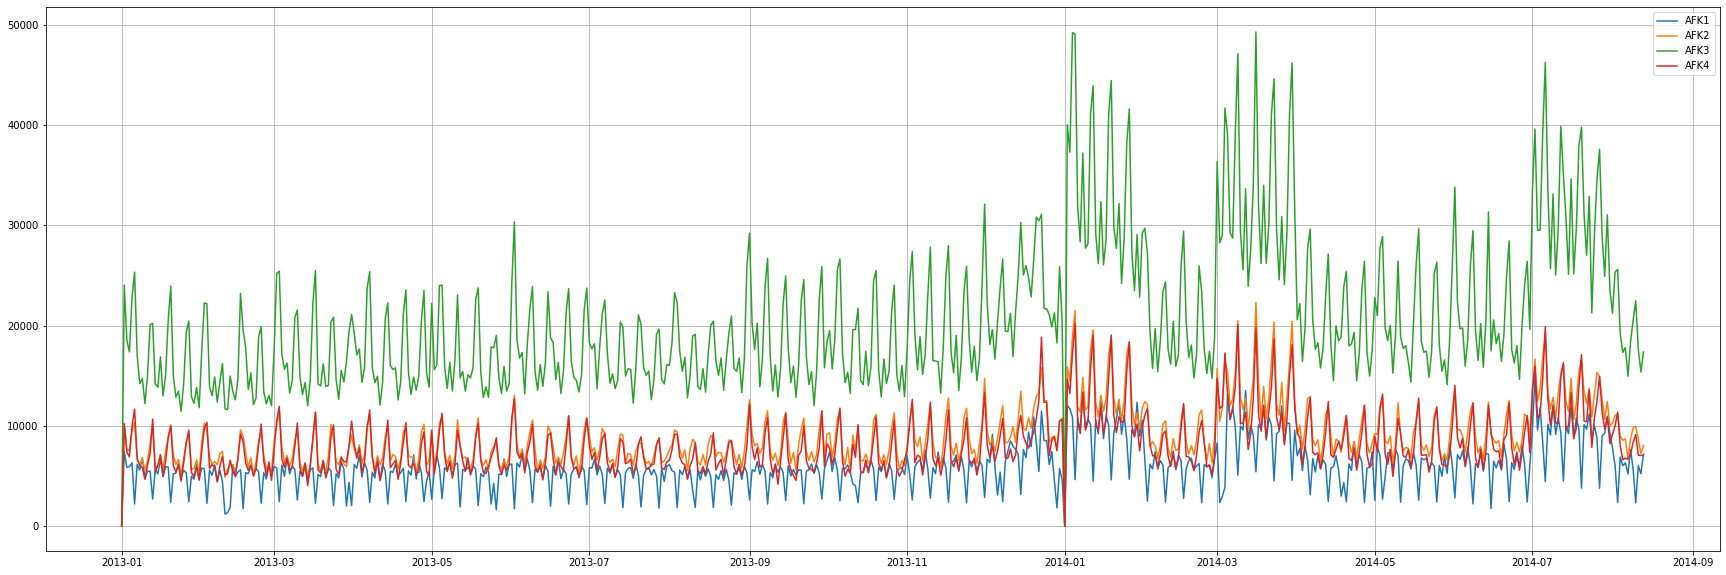

In [24]:
plt.figure(figsize=(30,10))
plt.plot(df1['penjualan'],label = 'AFK1')
plt.plot(df2['penjualan'],label = 'AFK2')
plt.plot(df3['penjualan'],label = 'AFK3')
plt.plot(df4['penjualan'],label = 'AFK4')
plt.legend()
plt.grid(visible = True)
plt.show()

Ada Peningkatan pada penjualan secara keseluruhan pada januari 2014, Maret 2014, dan juli 2014



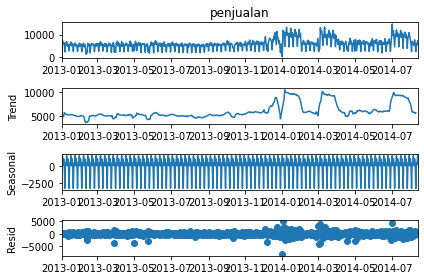

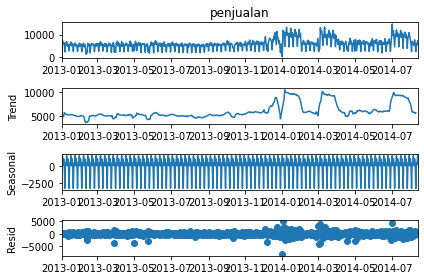

In [25]:
df1_dec = seasonal_decompose(df1.penjualan, model = 'additive')
df1_dec.plot()

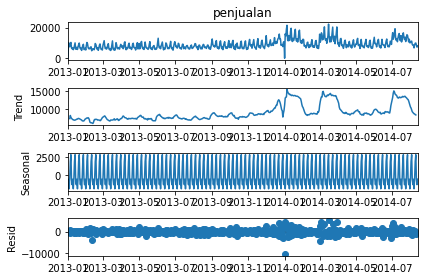

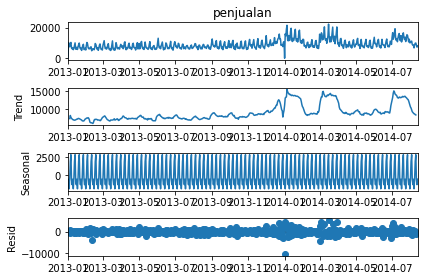

In [26]:
df2_dec = seasonal_decompose(df2.penjualan, model = 'additive')
df2_dec.plot()

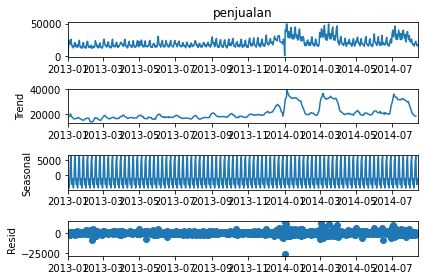

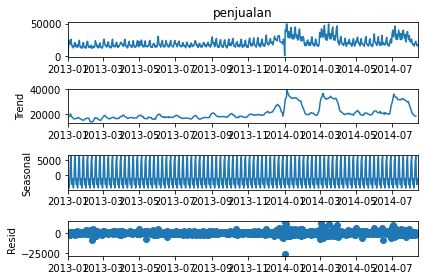

In [27]:
df3_dec = seasonal_decompose(df3.penjualan, model = 'additive')
df3_dec.plot()

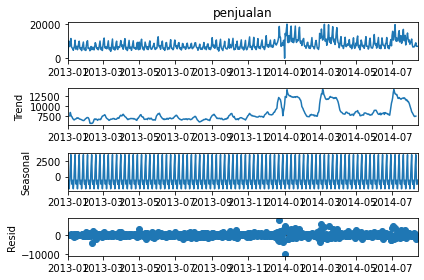

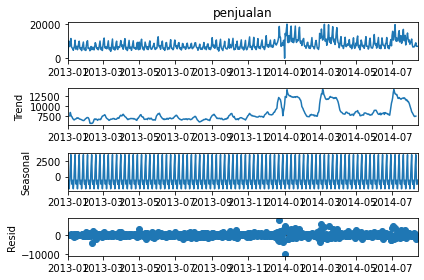

In [28]:
df4_dec = seasonal_decompose(df4.penjualan, model = 'additive')
df4_dec.plot()

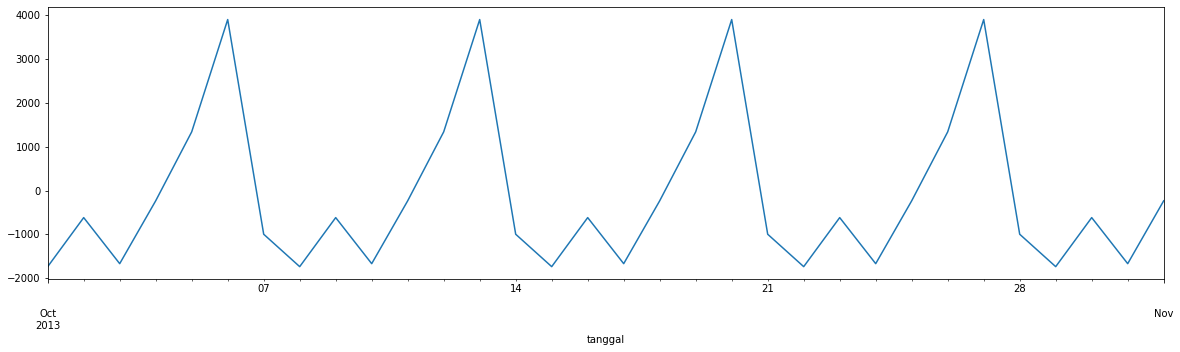

In [29]:
plt.figure(figsize = (20,5))
seasonal_decompose(df4.loc['2013-10-01':'2013-11-01'].penjualan, model = 'additive').seasonal.plot()

###### Seasonality Toko 4
Hari Selasa dan Kamis ada drop pada penjualan. Jumat Sabtu Minggu Penjualan meningkat dengan peak di hari minggu. Senin penjualan turun banyak dari hari minggu (Tgl 7 hari senin)

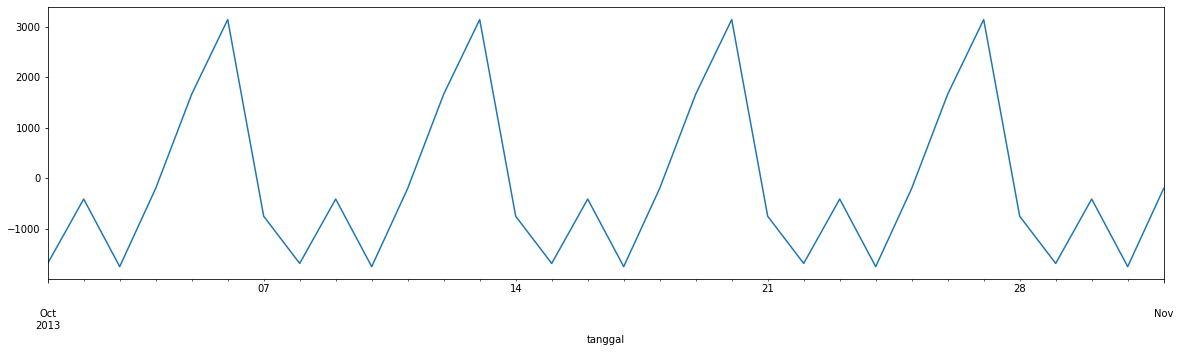

In [30]:
plt.figure(figsize = (20,5))
seasonal_decompose(df2.loc['2013-10-01':'2013-11-01'].penjualan, model = 'additive').seasonal.plot()

###### Seasonality Toko 2
Hari Selasa dan Kamis ada drop pada penjualan. Jumat Sabtu Minggu Penjualan meningkat dengan peak di hari minggu. Senin penjualan turun banyak dari hari minggu (Tgl 7 hari senin)

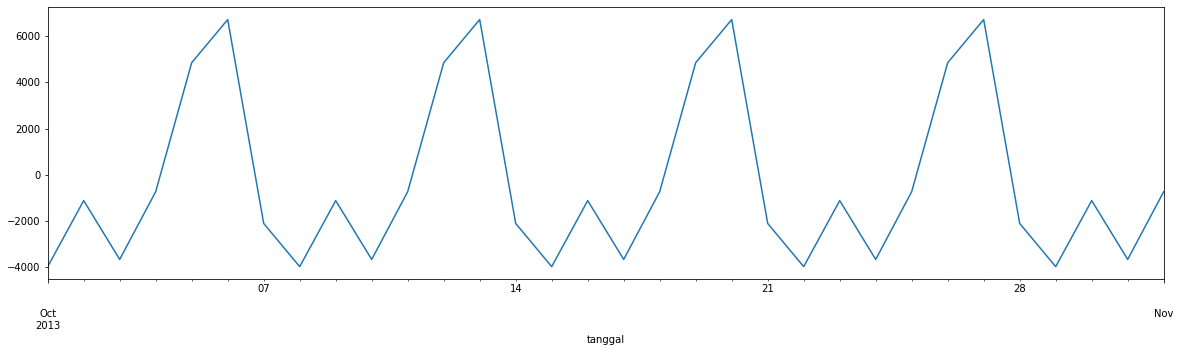

In [31]:
plt.figure(figsize = (20,5))
seasonal_decompose(df3.loc['2013-10-01':'2013-11-01'].penjualan, model = 'additive').seasonal.plot()

###### Seasonality toko 3
Hari Selasa dan Kamis ada drop pada penjualan. Jumat Sabtu Minggu Penjualan meningkat dengan peak di hari minggu. Senin penjualan turun banyak dari hari minggu (Tgl 7 hari senin)

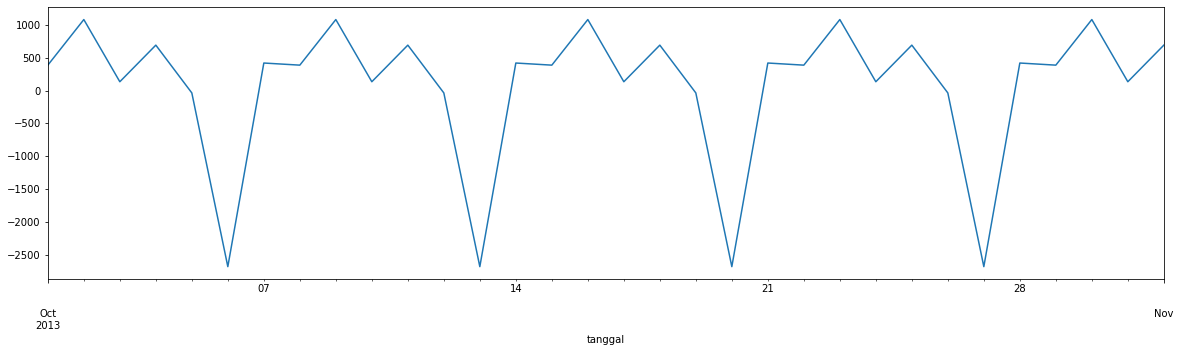

In [32]:
plt.figure(figsize = (20,5))
seasonal_decompose(df1.loc['2013-10-01':'2013-11-01'].penjualan, model = 'additive').seasonal.plot()

###### Seasonality toko 1
 Lowest di hari minggu. Sharp rise di hari senin, stagnan di selasa, naik di rabu, turun sedikit di kamis, naik di jumat, turun smp minggu. (Tgl 7 Hari Senin)

##### Cek Stasionaritas

In [33]:
def cek_stationary(sales):
    result = adfuller(sales)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('lags-used: {}'.format(result[2]))
    print('number of Observations: {}'.format(result[3]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] < 0.05:
      print('stasioner')

In [34]:
cek_stationary(df1.penjualan)

ADF Statistic: -3.444444990384352
p-value: 0.00953389501219897
lags-used: 17
number of Observations: 572
Critical Values:
	1%: -3.441834071558759
	5%: -2.8666061267054626
	10%: -2.569468095872659
stasioner


In [35]:
cek_stationary(df2.penjualan)

ADF Statistic: -3.0685852835291736
p-value: 0.028967068987444822
lags-used: 16
number of Observations: 573
Critical Values:
	1%: -3.4418139386911513
	5%: -2.866597262008035
	10%: -2.5694633721967906
stasioner


In [36]:
cek_stationary(df3.penjualan)

ADF Statistic: -3.0174344195087404
p-value: 0.033298012054017966
lags-used: 16
number of Observations: 573
Critical Values:
	1%: -3.4418139386911513
	5%: -2.866597262008035
	10%: -2.5694633721967906
stasioner


In [37]:
cek_stationary(df4.penjualan)

ADF Statistic: -3.0128942114517976
p-value: 0.03370766345922335
lags-used: 16
number of Observations: 573
Critical Values:
	1%: -3.4418139386911513
	5%: -2.866597262008035
	10%: -2.5694633721967906
stasioner


##### Cek Autokorelasi

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


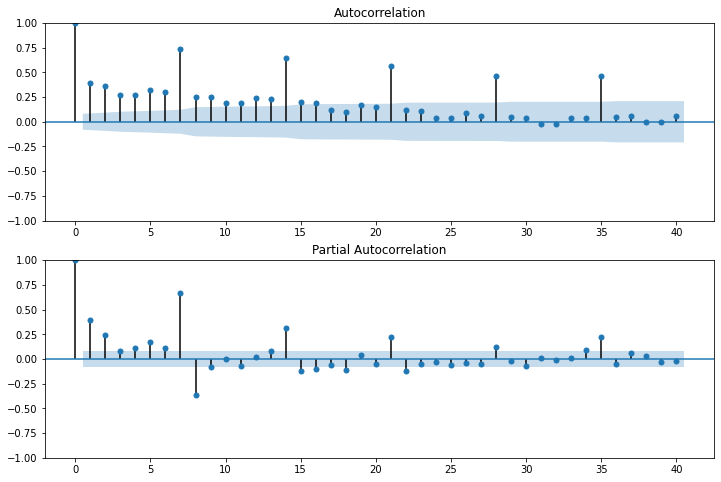

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1.penjualan.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1.penjualan.dropna(),lags=40,ax=ax2)

###### Toko 1
- ACF memiliki seasonal pattern [7], significance hingga acf tinggi 
- PACF juga banyak value yang significant

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


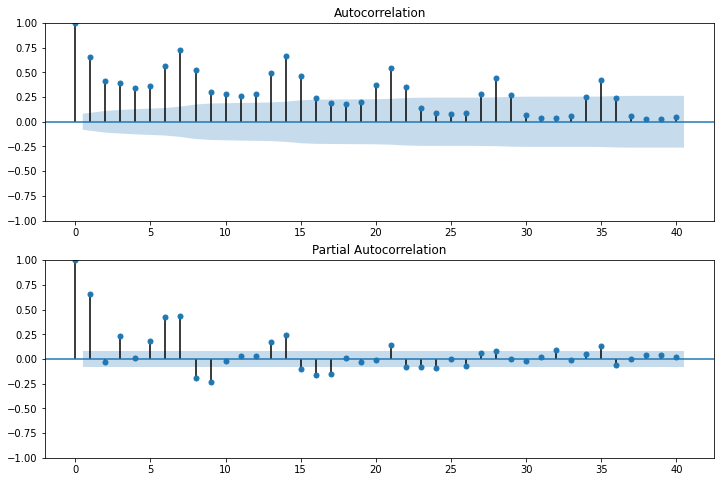

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.penjualan.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.penjualan.dropna(),lags=40,ax=ax2)

###### Toko 2
- ACF memiliki seasonal pattern [7], significance hingga acf tinggi 
- PACF juga banyak value yang significant

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


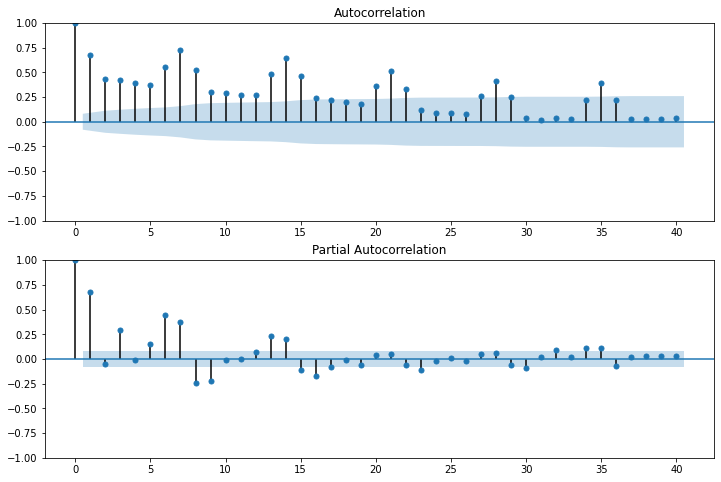

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df3.penjualan.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df3.penjualan.dropna(),lags=40,ax=ax2)

###### Toko 3
- ACF memiliki seasonal pattern [7], significance hingga acf tinggi 
- PACF juga banyak value yang significant

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


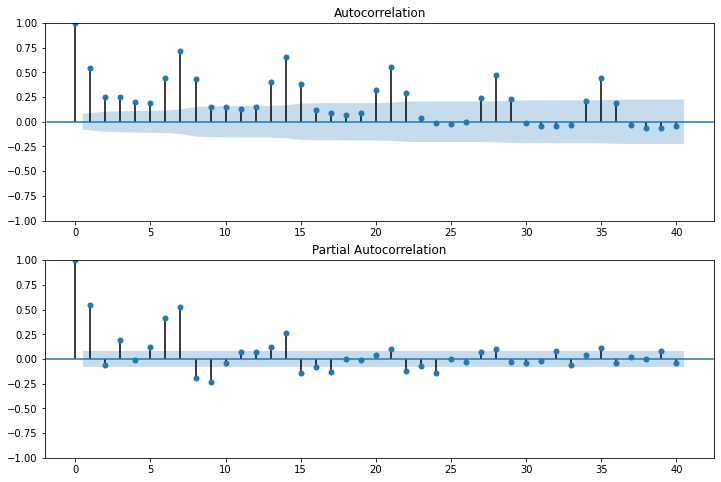

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df4.penjualan.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df4.penjualan.dropna(),lags=40,ax=ax2)

###### Toko 4
- ACF memiliki seasonal pattern [7], significance hingga acf tinggi 
- PACF juga banyak value yang significant

##### Train Test Split

Testing data 7 hari terakhir

In [42]:
df1_train = df1.loc[:'2014-08-6']['penjualan']
df1_test = df1.loc['2014-08-7':]['penjualan']

In [43]:
df2_train = df2.loc[:'2014-08-6']['penjualan']
df2_test = df2.loc['2014-08-7':]['penjualan']

In [44]:
df3_train = df3.loc[:'2014-08-6']['penjualan']
df3_test = df3.loc['2014-08-7':]['penjualan']

In [45]:
df4_train = df4.loc[:'2014-08-6']['penjualan']
df4_test = df4.loc['2014-08-7':]['penjualan']

#### MODELING

In [48]:
sarima_model1 = pm.auto_arima(
    y=df1_train,                
    seasonal=True,            
    test='kpss',              
    seasonal_test ='ocsb',     
    start_p=1, max_p=3,        
    #d=0,                    
    start_q=1, max_q=3,        
    start_P=1, max_P=3,        
    #D=1,                  
    start_Q=1, max_Q=3,      
    m=7      ,
    trace=True,
    stepwise=True,
    error_action='ignore',  
    suppress_warnings=True, 
)
sarima_model1

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=9957.372, Time=4.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10771.294, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10169.654, Time=1.84 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10313.905, Time=2.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10769.306, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10283.197, Time=4.18 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=9.01 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=10491.762, Time=1.44 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10280.873, Time=4.16 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=9964.534, Time

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [49]:
with open('model_toko1.pkl', 'wb') as pkl:
    pickle.dump(sarima_model1, pkl)

In [50]:
sarima_model2 = pm.auto_arima(
    y=df2_train,                
    seasonal=True,            
    #test='kpss',               
    #seasonal_test ='ocsb',     
    start_p=1, max_p=3,        
    d=1,                    
    start_q=1, max_q=3,       
    start_P=1, max_P=3,        
    D=1,                   
    start_Q=1, max_Q=3,      
    m=7      ,              
    trace=True,
    stepwise=True,
    error_action='ignore',  
    suppress_warnings=True, 
)
sarima_model2

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=10531.007, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=10283.712, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=10449.549, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=10236.350, Time=1.95 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=10219.345, Time=3.32 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=5.40 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.86 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=10296.512, Time=0.85 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=10159.044, Time=5.46 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=10170.896, Time=2.08 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=7.92 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.52 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=10160.646, Ti

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(3, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [51]:
with open('model_toko2.pkl', 'wb') as pkl:
    pickle.dump(sarima_model2, pkl)

In [52]:
sarima_model3 = pm.auto_arima(
    y=df3_train,                
    seasonal=True,            
    #test='kpss',              
    #seasonal_test ='ocsb',    
    start_p=1, max_p=3,        
    d=0,                    
    start_q=1, max_q=3,        
    start_P=1, max_P=3,        
    D=1,                   
    start_Q=1, max_Q=3,      
    m=7      ,               
    trace=True,
    stepwise=True,
    error_action='ignore',  
    suppress_warnings=True, 
)
sarima_model3

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=11525.597, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=11222.789, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=11243.710, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=11523.677, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=11334.123, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=11207.035, Time=0.76 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=11194.217, Time=1.47 sec
 ARIMA(1,0,0)(3,1,1)[7] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(0,0,0)(3,1,0)[7] intercept   : AIC=11449.730, Time=1.73 sec
 ARIMA(2,0,0)(3,1,0)[7] intercept   : AIC=11175.446, Time=1.86 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=11189.951, Time=1.15 sec
 ARIMA(2,0,0)(3,1,1)[7] intercept   : AIC=inf, Time=8.96 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=i

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(1, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [53]:
with open('model_toko3.pkl', 'wb') as pkl:
    pickle.dump(sarima_model3, pkl)

In [54]:
sarima_model4 = pm.auto_arima(
    y=df4_train,                
    seasonal=True,           
    test='kpss',               
    seasonal_test ='ocsb',     
    start_p=1, max_p=5,        
    #d=1,                    
    start_q=1, max_q=5,        
    start_P=1, max_P=5,        
    #D=1,                   
    start_Q=1, max_Q=5,      
    m=7      ,               
    trace=True,
    stepwise=True,
    error_action='ignore',  
    suppress_warnings=True, 
)
sarima_model4

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10891.144, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10534.314, Time=0.90 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10633.115, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10889.155, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=10877.663, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=10448.064, Time=1.37 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=10427.692, Time=3.10 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=10440.107, Time=3.46 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=inf, Time=10.07 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : AIC=10505.851, Time=3.62 sec
 ARIMA(2,1,0)(3,0,0)[7] intercept   : AIC=10349.661, Time=3.63 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(5, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [58]:
with open('model_toko4.pkl', 'wb') as pkl:
    pickle.dump(sarima_model4, pkl)

In [46]:
with open('model_toko1.pkl', 'rb') as pkl:
  sarima_model1 = pickle.load(pkl)
with open('model_toko2.pkl', 'rb') as pkl:
  sarima_model2 = pickle.load(pkl)
with open('model_toko3.pkl', 'rb') as pkl:
  sarima_model3 = pickle.load(pkl)
with open('model_toko4.pkl', 'rb') as pkl:
  sarima_model4 = pickle.load(pkl)

In [47]:
prediction1, confint1 = sarima_model1.predict(n_periods=7, return_conf_int=True)
predicted_values1, confint1 = sarima_model1.predict(
    n_periods=1*7, 
    return_conf_int=True
)
confint_df1 = pd.DataFrame(confint1)
date_index1 = pd.date_range(
    start = df1_train.index[-1]+timedelta(days=1),
    periods = 1*7,
    freq='D'
)

predicted_df1 = pd.DataFrame({'value':predicted_values1}, index=date_index1)
predicted_df1

,value
2014-08-07,5457.124122
2014-08-08,7106.403150
2014-08-09,5948.557561
2014-08-10,1868.533841
2014-08-11,6097.934868
2014-08-12,5935.361371
2014-08-13,7595.935349


In [48]:
prediction2, confint2 = sarima_model2.predict(n_periods=7, return_conf_int=True)
predicted_values2, confint2 = sarima_model2.predict(
    n_periods=1*7, 
    return_conf_int=True
)
confint_df2 = pd.DataFrame(confint2)
date_index2 = pd.date_range(
    start = df2_train.index[-1]+timedelta(days=1),
    periods = 1*7,
    freq='D' 
)

predicted_df2 = pd.DataFrame({'value':predicted_values2}, index=date_index2)
predicted_df2

,value
2014-08-07,6341.720225
2014-08-08,8228.985871
2014-08-09,10085.827064
2014-08-10,10504.579434
2014-08-11,7770.302097
2014-08-12,6542.554207
2014-08-13,8071.249809


In [49]:
prediction3, confint3 = sarima_model3.predict(n_periods=7, return_conf_int=True)
predicted_values3, confint3 = sarima_model3.predict(
    n_periods=1*7, 
    return_conf_int=True
)
confint_df3 = pd.DataFrame(confint3)
date_index3 = pd.date_range(
    start = df3_train.index[-1]+timedelta(days=1),
    periods = 1*7,
    freq='D' 
)

predicted_df3 = pd.DataFrame({'value':predicted_values3}, index=date_index3)
predicted_df3

,value
2014-08-07,14537.589444
2014-08-08,18224.837903
2014-08-09,25242.900124
2014-08-10,27110.711180
2014-08-11,19396.729049
2014-08-12,17497.892858
2014-08-13,20981.573897


In [50]:
prediction4, confint4 = sarima_model4.predict(n_periods=7, return_conf_int=True)
predicted_values4, confint4 = sarima_model4.predict(
    n_periods=1*7, 
    return_conf_int=True
)
confint_df4 = pd.DataFrame(confint4)
date_index4 = pd.date_range(
    start = df4_train.index[-1]+timedelta(days=1),
    periods = 1*7,
    freq='D' 
)

predicted_df4 = pd.DataFrame({'value':predicted_values4}, index=date_index4)
predicted_df4

,value
2014-08-07,5240.675725
2014-08-08,6896.828097
2014-08-09,8937.189575
2014-08-10,11446.549960
2014-08-11,6980.452204
2014-08-12,5862.533114
2014-08-13,7268.005955


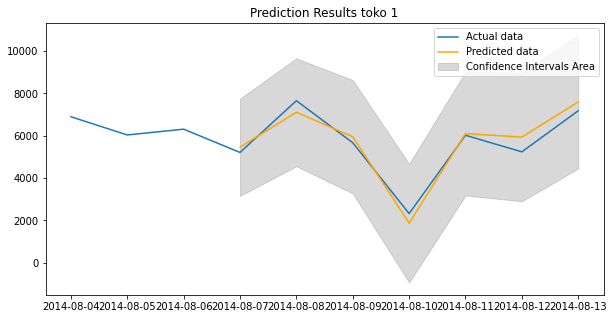

In [51]:
plt.figure(figsize=(10,5))
plt.plot(df1['penjualan'][-10:], label='Actual data')
plt.plot(predicted_df1['value'], color='orange', label='Predicted data')
plt.fill_between(date_index1, confint_df1[0], confint_df1[1],color='grey',alpha=.3, label='Confidence Intervals Area')
plt.title('Prediction Results toko 1')
plt.legend()
plt.show()

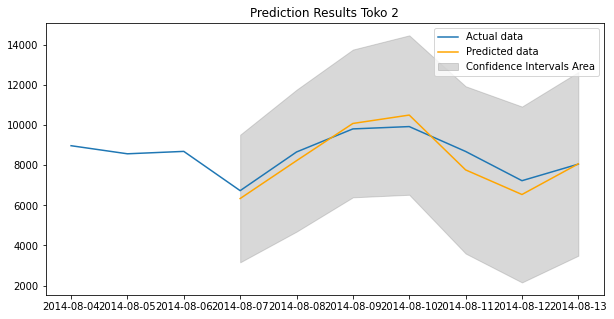

In [52]:
plt.figure(figsize=(10,5))
plt.plot(df2['penjualan'][-10:], label='Actual data')
plt.plot(predicted_df2['value'], color='orange', label='Predicted data')
plt.fill_between(date_index2, confint_df2[0], confint_df2[1],color='grey',alpha=.3, label='Confidence Intervals Area')
plt.title('Prediction Results Toko 2')
plt.legend()
plt.show()

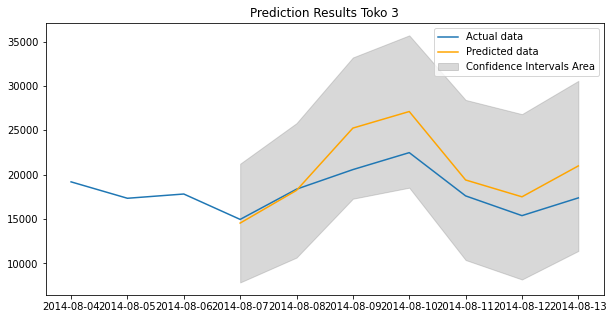

In [53]:
plt.figure(figsize=(10,5))
plt.plot(df3['penjualan'][-10:], label='Actual data')
plt.plot(predicted_df3['value'], color='orange', label='Predicted data')
plt.fill_between(date_index3, confint_df3[0], confint_df3[1],color='grey',alpha=.3, label='Confidence Intervals Area')
plt.title('Prediction Results Toko 3')
plt.legend()
plt.show()

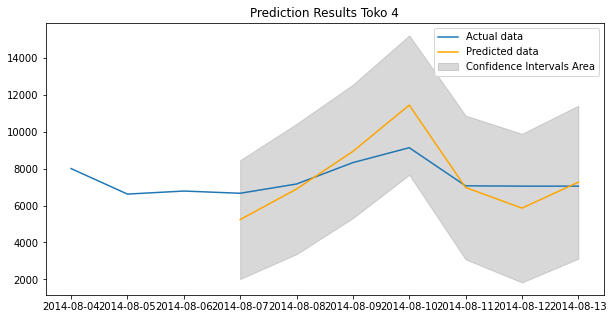

In [54]:
plt.figure(figsize=(10,5))
plt.plot(df4['penjualan'][-10:], label='Actual data')
plt.plot(predicted_df4['value'], color='orange', label='Predicted data')
plt.fill_between(date_index4, confint_df4[0], confint_df4[1],color='grey',alpha=.3, label='Confidence Intervals Area')
plt.title('Prediction Results Toko 4')
plt.legend()
plt.show()

#### EVALUATION MODEL

In [55]:
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))

In [56]:
print('MAPE toko 1:',calcsmape(df1_test,prediction1))
print('MAPE toko 2:',calcsmape(df2_test,prediction2))
print('MAPE toko 3:',calcsmape(df3_test,prediction3))
print('MAPE toko 4:',calcsmape(df4_test,prediction4))

MAPE toko 1: 0.08283044712541554
MAPE toko 2: 0.058343735806764274
MAPE toko 3: 0.12007365272454933
MAPE toko 4: 0.11435764725235367


MAPE Cukup bagus

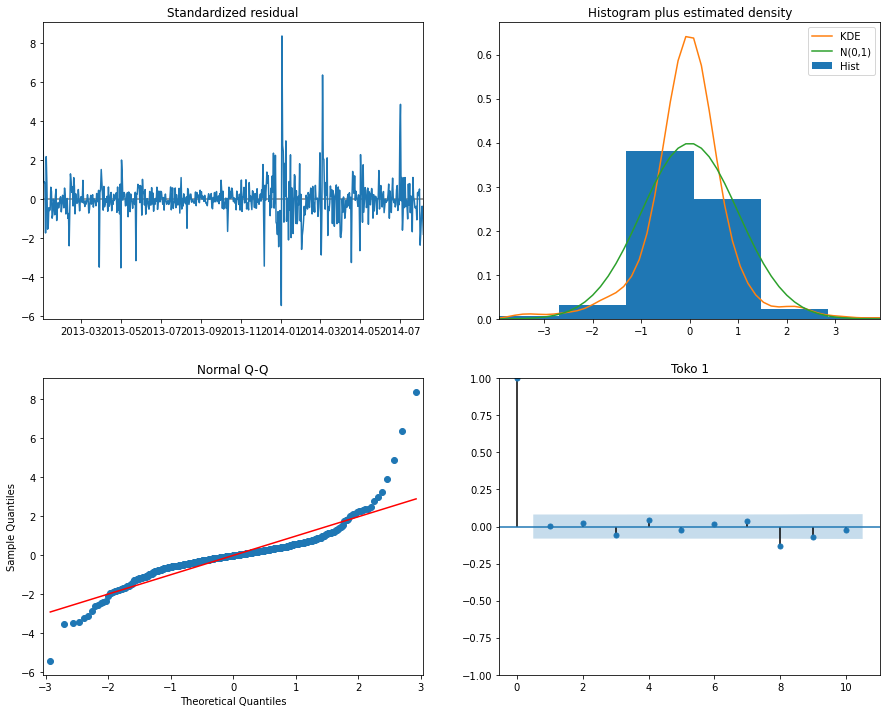

In [57]:
#toko 1
sarima_model1.plot_diagnostics(figsize=(15,12))
plt.title('Toko 1')
plt.show()

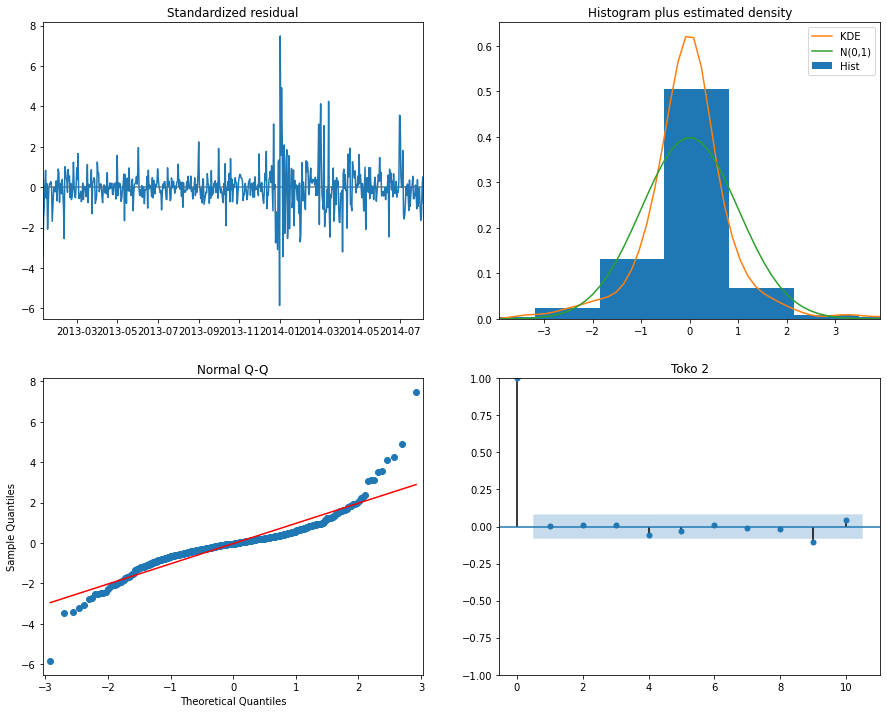

In [58]:
#toko 2
sarima_model2.plot_diagnostics(figsize=(15,12))
plt.title('Toko 2')
plt.show()

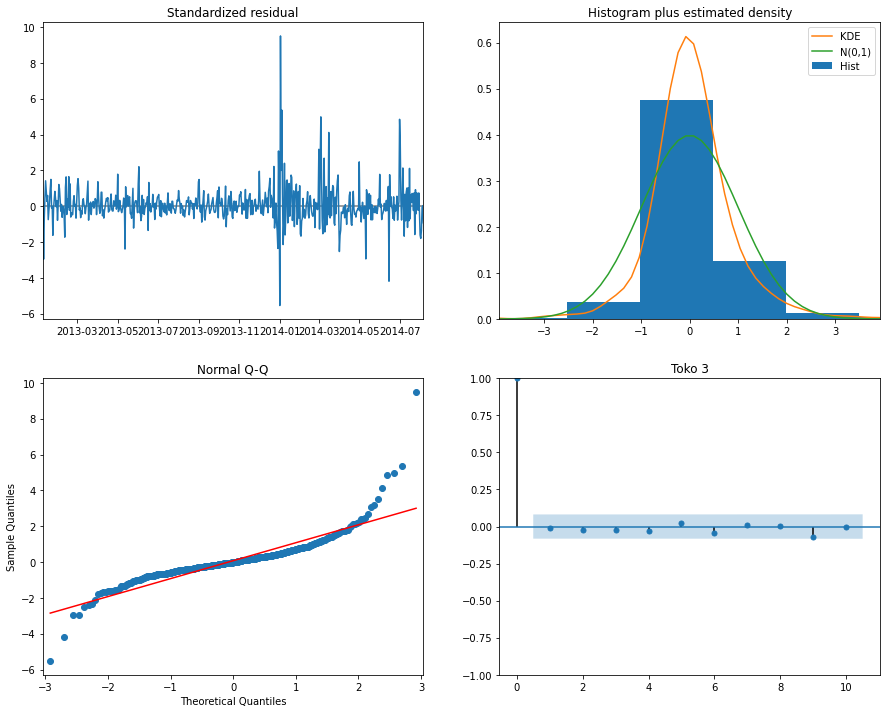

In [59]:
#toko 3
sarima_model3.plot_diagnostics(figsize=(15,12))
plt.title('Toko 3')
plt.show()

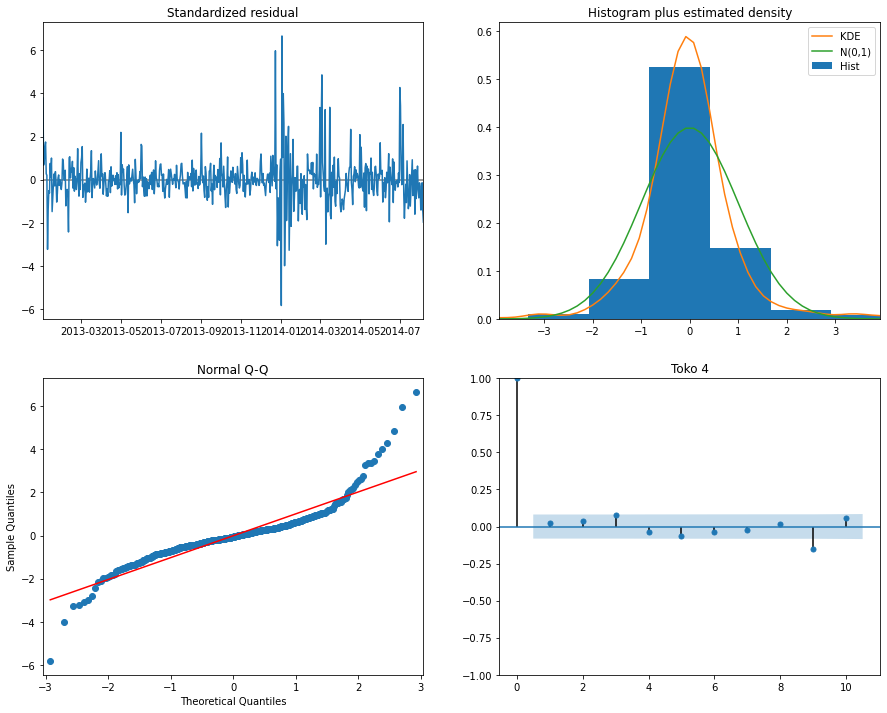

In [60]:
#toko 4
sarima_model4.plot_diagnostics(figsize=(15,12))
plt.title('Toko 4')
plt.show()

### KESIMPULAN/SARAN

- Toko paling Laris Toko 3
- Toko 1 memiliki seasonality yang berbeda sendiri dengan toko lainnya (hari minggu toko lain peak namun lowest di toko 1)
- Barang paling laku adalah GROCERY 1
- Ada Peningkatan trend pada penjualan secara keseluruhan pada januari 2014, Maret 2014, dan Juli 2014 namun data blm cukup untuk apakah secara yearly akan ada peningkatan pada total penjualan secara keseluruhan karena level penjualan bulan lain cukup mirip dengan level penjualan tahun sebelumnya
- Model forecasting dapat digunakan dalam produksi karena MAPE cukup rendah sehingga hasil dapat dipercaya apabila hanya digunakan sebagai estimasi

### Saran
- Ada yang tidak diisi di beberapa tanggal. Agar hasil forecasting dapat semakin baik, diharapkan agar data entry dapat dilakukan secara konsisten


# Deployment

In [61]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
from flask import Flask, render_template, redirect, request, url_for, jsonify
from flask_ngrok import run_with_ngrok
import json

In [63]:
#mendefinisikan ngrok
app = Flask(__name__)
run_with_ngrok(app) 

In [64]:
@app.route('/time_series/predict', methods=['GET', 'POST'])
def predict():
    start_time = datetime.now()
    models = ['model_toko1.pkl','model_toko2.pkl','model_toko3.pkl','model_toko4.pkl']
    nomor_toko = request.json['toko']
    horizon = request.json['horizon']
    with open(models[(int(nomor_toko)-1)], 'rb') as pkl:
      preds = pickle.load(pkl).predict(n_periods=(int(horizon)+7))[7:]

    
    df_pred = preds.to_frame().reset_index()
    df_pred = df_pred.rename(columns= {'index': 'tanggal',0:'penjualan'})
    df_pred['tanggal'] = df_pred['tanggal'].dt.strftime("%d-%m-%Y")
    df_pred.set_index('tanggal',inplace=True)
    #df_pred.drop(columns = ['tanggal'], inplace=True)
    end_time = datetime.now()
    print("\nDuration_forecast: {}".format(end_time - start_time))
    print(f'\nForecast toko {nomor_toko} dengan horizon {horizon} hari\n\n')
    print(df_pred)

    #return (jsonify(preds))
    result = {"result":"success"}
    return (json.loads(df_pred.to_json(orient="columns")))

In [65]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://52ba-35-247-33-161.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [29/Sep/2022 12:23:43] "POST /time_series/predict HTTP/1.1" 200 -



Duration_forecast: 0:00:00.059938

Forecast toko 3 dengan horizon 7 hari


               penjualan
tanggal                 
14-08-2014  16325.682917
15-08-2014  19672.912386
16-08-2014  27157.028278
17-08-2014  28847.905611
18-08-2014  20836.147408
19-08-2014  18868.929056
20-08-2014  22362.980532
